'1.6.0'

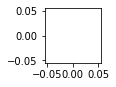

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
# force plt on windows 10
import matplotlib.pyplot as plt
plt.figure(figsize=(1,1))
plt.plot()

import sys
sys.path.append("..")

import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import aggets.ds.window as window
import aggets.ds.hyper_f_load as hfl
import aggets.ds.window as window
import aggets.train as train

## DISABLE THIS
import warnings
warnings.filterwarnings("ignore")
torch.__version__

In [2]:
def load_data(path, train_p, vali_p, test_p):
    data_test = pd.read_csv(path, index_col=0)
    n = data_test.shape[0]
    print(n)
    train_df, vali_df, test_df = data_test[:int(n*train_p)], data_test[int(n*train_p):int(n*(train_p+vali_p))], data_test[int(n*(train_p+vali_p)):]

    num_features = data_test.shape[1]
    column_indices = {name: i for i, name in enumerate(data_test.columns[:-1])}
    cols = ['att' + str(i + 1) for i, name in enumerate(data_test.columns[:-1])]

    data_obj = {'train': train_df, 'val': vali_df, 'test': test_df, 'features': num_features, 'column_indices': column_indices , 'df': data_test, 'cols': cols}

    return data_obj

In [3]:
import pp.data_loader as dl

path = './data/ts/hyperplane/hyper_f.csv'
paths = ['./data/ts/numbers/numbers.csv', './data/ts/adults/fin_adult.csv']

#data = pd.read_csv(paths[1])
#data.shape

data = dl.create_data_object_csv(paths[1], .7, .2, .1)

In [4]:
import aggets.ds.aggregate_nd as agg_nd
'''
df = data['val']
cols = data['cols']
lab_col = 'class'
print(df[cols + [lab_col]].to_numpy())

'''


cols = data['cols']
train_np = agg_nd.as_np(data['train'], cols, 'class')
val_np = agg_nd.as_np(data['val'], cols, 'class')
test_np = agg_nd.as_np(data['test'], cols, 'class')

window = agg_nd.window_generator(train_np, val_np, test_np, window_size=100, e=0.00001, hist_bins=20, hist_dim=1)



ranges -> [[-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1.00000e-05  1.00001e+00]
 [-1

In [131]:
#window.init_structures()

In [5]:
import aggets.util as util

filename = 'window_fin_adult.bin'
#util.save(window, path=filename)
w = util.load(path=filename)

In [55]:
print('aggregates')
print(w.train_agges.shape)
print(w.val_agges.shape)
print(w.test_agges.shape)
print('models')
print(w.train_models.shape)
print(w.val_models.shape)
print(w.test_models.shape)
print('')
from aggets.model.aggregate import WindowConfig
dl = w.wrapped(WindowConfig(output_sequence_length=5, input_sequence_length=10),
              other={'source': 'agg', 'target': 'lr'}).train

print('sets')
def get_item_shape(item):
    if type(item) == list:
       return (item[0].shape, item[1].shape)
    return item.shape
[get_item_shape(l) for l in next(iter(dl))]


aggregates
torch.Size([341, 5, 2, 65, 20])
torch.Size([97, 5, 2, 65, 20])
torch.Size([48, 5, 2, 65, 20])
models
torch.Size([341, 5, 66])
torch.Size([97, 5, 66])
torch.Size([48, 5, 66])

sets


[torch.Size([32, 10, 2, 65, 20]), torch.Size([32, 5, 66])]

# LSTM WITH ATTENTION MECHANISM TESTS

In [106]:
import pp.aggregate_pp as agg_m
import aggets.model.simple as simple

# HIST -> LR
hidden = 256
size = 2*65*20

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=1, out_features=66)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

training model autoreg-lstm


RuntimeError: Sizes of tensors must match except in dimension 2. Got 1 and 32 in dimension 0 (The offending index is 1)

<Figure size 432x288 with 0 Axes>

# AUTOLSTM

## agg -> lr

training model autoreg-lstm
saving model MTL=2.172220727885651e+24, MVL=2.004892184042846e+24
saving model MTL=2.1717999765295937e+24, MVL=2.0020971725136142e+24
saving model MTL=2.1715666229564308e+24, MVL=1.9945433610733886e+24
saving model MTL=2.1780516594788682e+24, MVL=1.9919154982193112e+24
saving model MTL=2.175159609574534e+24, MVL=1.9860066868219314e+24
saving model MTL=2.1734218714625034e+24, MVL=1.9855819959913475e+24


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

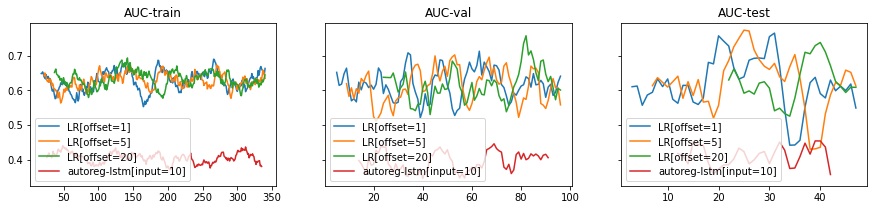

In [101]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST -> LR
hidden = 256
size = 2*65*20

flatten = agg_m.Flatten(out_seq=5)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=1, out_features=66)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=5, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='agg', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'agg', 'target':'lr'})

## all -> lr

training model autoreg-lstm
saving model MTL=2.1731372595078874e+24, MVL=1.991946981845014e+24
saving model MTL=2.171848315872041e+24, MVL=1.9898099198926045e+24
saving model MTL=2.1733081207793974e+24, MVL=1.9896627450282278e+24
saving model MTL=2.173161227841716e+24, MVL=1.9895893793117136e+24
saving model MTL=2.1725355884879287e+24, MVL=1.9880672956670666e+24
saving model MTL=2.1727157847501016e+24, MVL=1.9867938550649856e+24
saving model MTL=2.1746020604084304e+24, MVL=1.9823056535911718e+24


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

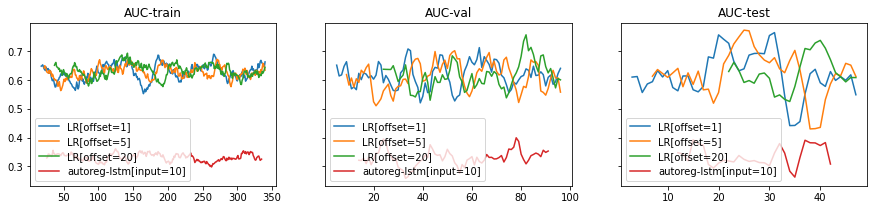

In [136]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> LR
hidden = 256
size_all= 2*65*20 + 66 

inp = nn.Sequential(
    agg_m.FlatCat(),
    simple.mlp(features=size_all, num_layers=1, out_features=hidden)
)
out = simple.mlp(features=hidden, num_layers=2, out_features=66)

lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001, 0.00001],
                          source='all', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'lr'})

## ag[0] -> ag[0] NOT WORKING

training model autoreg-lstm
saving model MTL=0.01269038963633088, MVL=0.007806107035971114
saving model MTL=0.006739513393348226, MVL=0.006817962674956236
saving model MTL=0.00658216005943429, MVL=0.006789280334487557
saving model MTL=0.006571420486300037, MVL=0.00677224641133632
saving model MTL=0.0065522205281572845, MVL=0.006751100931848798


<Figure size 432x288 with 0 Axes>

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

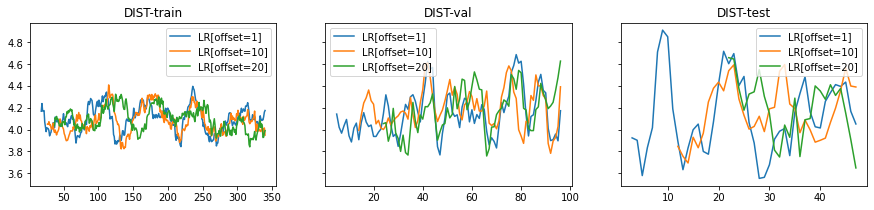

In [139]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST[0] -> HIST[0]
size = 65*20#2250 // 2
hidden = 256
_out = 1

flatten = agg_m.Flatten(out_seq=_out)
inp = nn.Sequential(
    flatten,
    simple.mlp(features=size, num_layers=1, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=1, out_features=size),
    flatten.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=_out, hidden=hidden)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='agg[0]', target='agg[0]', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
# offset changed from default[1, 20, 50] to [1, 10, 20] 
w.plot_agg_dist(axs=axs, select=lambda a: a[:, 0, 0], offsets=[1, 10, 20])
w.plot_model_agg_dist(model=lstm, axs=axs, other={'source': 'agg[0]', 'target': 'agg[0]'})

## lr -> lr

training model autoreg-lstm
saving model MTL=2.172476981644778e+24, MVL=1.9977076483719435e+24
saving model MTL=2.176181644817594e+24, MVL=1.995526404028605e+24
saving model MTL=2.1726144011281842e+24, MVL=1.992504469278518e+24
saving model MTL=2.1721266362096716e+24, MVL=1.9919439775976318e+24
saving model MTL=2.1729113843826706e+24, MVL=1.9852160320999045e+24


<Figure size 432x288 with 0 Axes>

saving model MTL=2.1716966431139552e+24, MVL=1.9841682814252418e+24
saving model MTL=2.1729111908161925e+24, MVL=1.9798200878566437e+24


<Figure size 432x288 with 0 Axes>

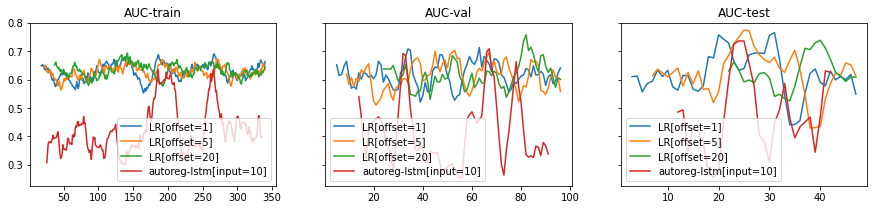

In [137]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# LR -> LR
size = 66
hidden = 16
inp = simple.mlp(features=size, num_layers=1, out_features=hidden)
out = simple.mlp(features=hidden, num_layers=1, out_features=size)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=5, hidden=16)
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=20, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'lr', 'target':'lr'})

## all -> all

training model autoreg-lstm
saving model MTL=2.2174631208103172e+24, MVL=2.068014039074494e+24
saving model MTL=2.1670332257070514e+24, MVL=1.9214495040041552e+24
saving model MTL=2.1586590886179461e+24, MVL=1.8582066733442727e+24


<Figure size 432x288 with 0 Axes>

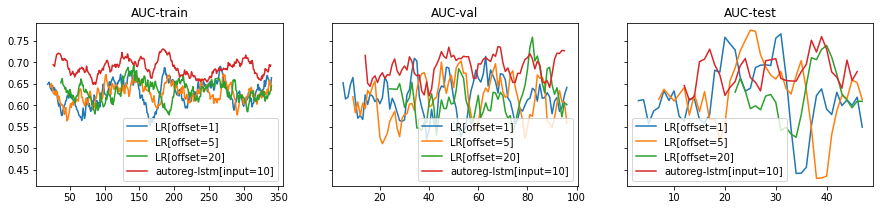

In [141]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
# HIST+LR -> HIST+LR
hidden = 512

flatcat = agg_m.FlatCat()

inp = nn.Sequential(
    flatcat,
    simple.mlp(features=size_all, num_layers=2, out_features=hidden)
)
out = nn.Sequential(
    simple.mlp(features=hidden, num_layers=2, out_features=size_all),
    flatcat.reverse()
)
lstm = agg_m.AutoregLstm(input=inp, output=out, in_len=10, out_len=1, hidden=hidden, num_layers=2)

loss = nn.MSELoss()

def criterion(x, y):
    return loss(x[0], y[0]) + loss(x[1], y[1])
# -------
lstm.name = 'autoreg-lstm'
train.train_window_models([lstm], w, patience=10, validate=True, weight_decay=0, max_epochs=1000,
                          lrs=[0.0001],
                          source='all', target='all', log=False,
                          criterion=criterion)
# -------
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(lstm, axs=axs, other={'source':'all', 'target':'all'}, select=lambda x: x[1])

# FOURIER

## agg[0] -> agg[0]


In [102]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# HIST[0] -> HIST[0]
size = 65*20

frr = fourier.HistogramLerner(extra_dims=1, t_in=65)
frr = fourier.FAdapter3(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=65, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='agg[0]', target='agg[0]', log=False)

training model fourier
d-2-shape torch.Size([1, 1, 65, 1])
saving model MTL=0.00889152022035316, MVL=0.006835187692195177


<Figure size 432x288 with 0 Axes>

saving model MTL=0.006726289016389569, MVL=0.006789241544902324


<Figure size 432x288 with 0 Axes>

training model fourier
saving model MTL=2.1715452018565136e+24, MVL=1.9469933677912178e+24
saving model MTL=2.1646552509676214e+24, MVL=1.8651644582395008e+24


<Figure size 432x288 with 0 Axes>

saving model MTL=2.177507308721972e+24, MVL=1.8621397150310763e+24


<Figure size 432x288 with 0 Axes>

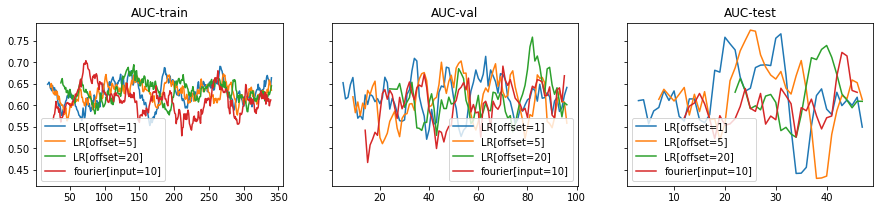

In [103]:
import aggets.model.aggregate2 as agg_m
import aggets.model.simple as simple
import aggets.model.fourier as fourier
# LR -> LR
size = 11

frr = fourier.HistogramLerner(extra_dims=0, t_in=10)
frr = fourier.FAdapter3(frr)
frr.window_config = WindowConfig(output_sequence_length=1, input_sequence_length=10, label_stride=1)
# -------
frr.name = 'fourier'
train.train_window_models([frr], w, patience=2, validate=True, weight_decay=0, max_epochs=10,
                          lrs=[0.001, 0.0001],
                          source='lr', target='lr', log=False)

# ------- lr
_, axs = plt.subplots(ncols=3, nrows=1, sharey='row', figsize=(15, 3))
w.plot_lr(axs=axs)
w.plot_model(frr, axs=axs, other={'source':'lr', 'target':'lr'})